# Motor Model Parameter Indentification
## Motor Characterization

<table>
  <tr>
    <td><img src="./Supporting_Files/IMG_2087.png" width="600" height="400"><br><strong>Setup</strong></td>
    <td><img src="./Supporting_Files/motorTracker.png" width="600" height="400"><br><strong>Tracker</strong></td>
  </tr>
</table>


In [1]:
import pandas as pd
import scipy.signal as ss
import scipy.optimize as so
import numpy as np
import matplotlib.pyplot as plt
import math

###  Massaging the Data

In [2]:
data = pd.read_csv("MotorData.txt")
data.ffill()
data.columns

Index(['t', 'Ax', 'Ay', 'Bx', 'By', 'Cx', 'Cy'], dtype='object')

In [3]:

# (A)================(B)================(C)

t = data['t']

Ax, Ay = data["Ax"], data["Ay"] # end left
Bx, By = data["Bx"], data["By"]  # center point
Cx, Cy = data["Cx"], data["Cy"]  # end right


# Calculate relative coordinates for each end point
Adx, Ady = Ax - Bx, Ay - By
Cdx, Cdy = Cx - Bx, Cy - By

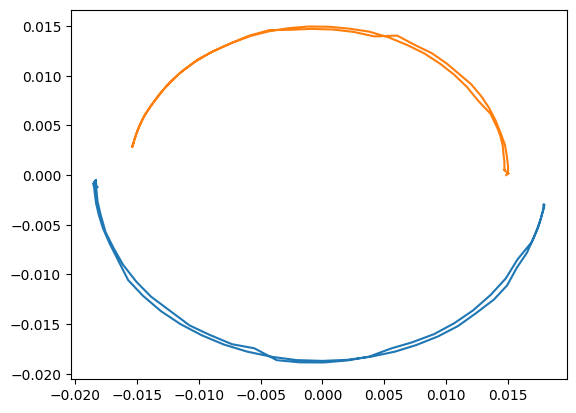

In [4]:
plt.plot(Adx,Ady)
plt.plot(Cdx, Cdy)
plt.show()

In [5]:
xini = Adx.mean()
yini = Adx.mean()
ini = np.array([xini,yini])

ini


array([-0.00355895, -0.00355895])

### Finding the Center of Rotation
Create a function that finds the sum of squared radii given an x,y coordinate guess for the center of rotation, across the two points tracked. By obtaining the distance from the guessed center to each point over all the data, the true center should minimize the sum of all distances to all tracked points.

In [6]:
def fun(guess):
    # break out guess into two variables, x0 and y0
    x0,y0 = guess
    # start with zero error
    error = 0
    # sum the squared length to point 1 over all time and add to error
    error += ((Adx-x0)**2+(Ady-y0)**2).sum()
    # sum the squared length to point 2 over all time and add to error
    error += ((Cdx-x0)**2+(Cdy-y0)**2).sum()
    # take the square root
    error = error**.5
    # return the error
    return error

print(fun(ini))

0.42008241200900365


In [7]:
result = so.minimize(fun,ini)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.40608270404082475
        x: [-4.676e-04 -3.470e-04]
      nit: 5
      jac: [-3.725e-09  3.725e-09]
 hess_inv: [[ 6.977e-04 -9.039e-11]
            [-9.039e-11  6.977e-04]]
     nfev: 27
     njev: 9

Compute the vectors from the origin to the two tracked points. This will effectively shift the original tracked points to move about the result of our optimization, the selected center of rotation in the video.

In [8]:
v1 = np.array([Adx-result.x[0],(Ady-result.x[1])]).T
v2 = np.array([Cdx-result.x[0],(Cdy-result.x[1])]).T

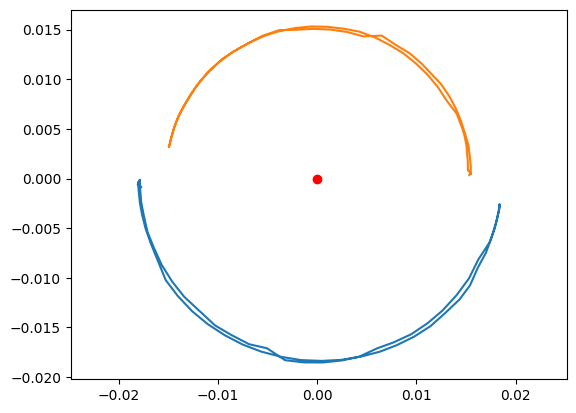

In [9]:
plt.plot(v1[:,0],v1[:,1])
plt.plot(v2[:,0],v2[:,1])
plt.plot(0,0,'ro')
plt.axis('equal')
plt.show()

The angle of each vector can be computed by taking the arctan of the x and y components of vector 1 and 2. Plot the result.

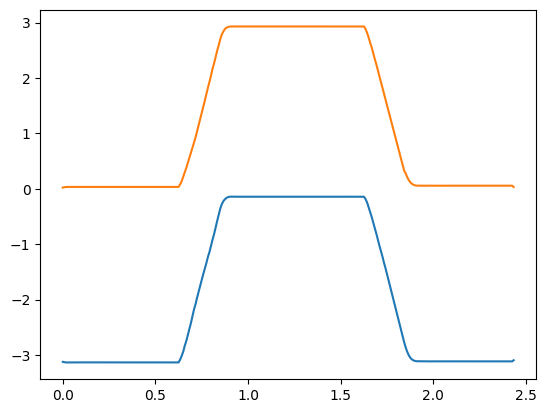

In [10]:
theta_v1 = np.arctan2(v1[:,1],v1[:,0])
theta_v2 = np.arctan2(v2[:,1],v2[:,0])
plt.plot(t,theta_v1)
plt.plot(t,theta_v2)
plt.show()

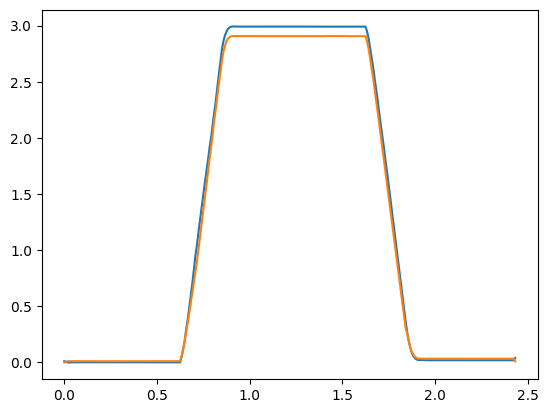

In [11]:
theta_v1 += abs(theta_v1.min()) # y axis shift to start near 0
theta_v2 -= theta_v2.min() # y axis shift to start near 0

plt.plot(t,theta_v1)
plt.plot(t,theta_v2)
plt.show()

Compute the average of these two samples. Adding even more points to this analysis would give us a more accurate measurement of theta

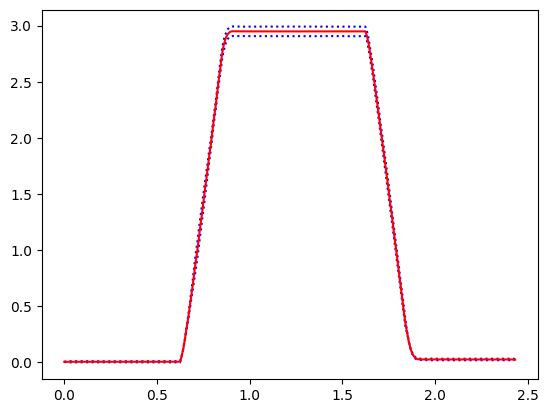

In [12]:
theta_avg = (theta_v1+theta_v2)/2
plt.plot(t,theta_v1,'b:')
plt.plot(t,theta_v2,'b:')
plt.plot(t,theta_avg,'r-')
plt.show()

In [13]:
tMax = theta_avg.max() # May be due to forced manipulation by hand
tMax*180/math.pi

np.float64(169.0110825837823)

### Guessing the Input Signal

In [14]:
time_filter = t<1

jj = theta_avg[time_filter] > \
(theta_avg[time_filter].max() - theta_avg[time_filter].min())*.01 \
+ theta_avg[time_filter].min()
t_0_kk = (t[time_filter][jj]).idxmin()
t_0 = t[t_0_kk]
t_0

np.float64(0.633)

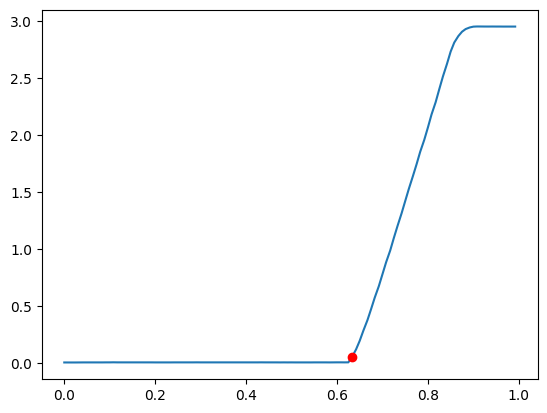

In [15]:
plt.plot(t[time_filter],theta_avg[time_filter])
plt.plot(t[t_0_kk],theta_avg[t_0_kk],'ro')
plt.show()

In [16]:
A = tMax
f = .5
w = .5
b = 0

def square(t, A, f, w, b, t_0):
    # Calculate the phase of the square wave
    phase = ((t - t_0) * f) % 1
    
    # Generate the square wave signal based on the phase and duty cycle 'w'
    return A * (phase < w) + b

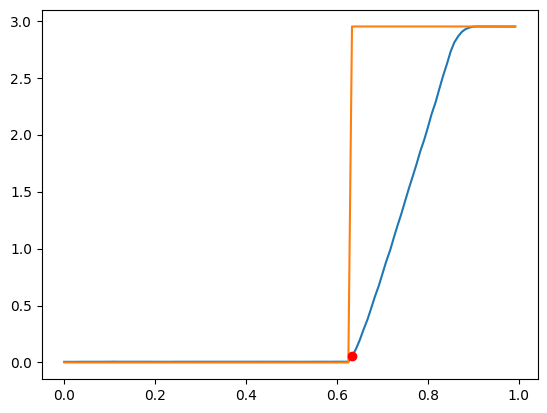

In [17]:
y = square(t,A,f,w,b,t_0)
plt.plot(t[time_filter],theta_avg[time_filter])
plt.plot(t[time_filter],y[time_filter])
plt.plot(t[t_0_kk],theta_avg[t_0_kk],'ro')
plt.show()

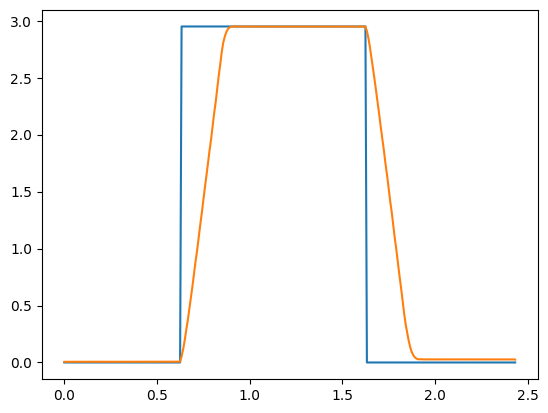

In [18]:
plt.plot(t,y)
plt.plot(t,theta_avg)
plt.show()

In [19]:
import yaml

data = {}
data['A'] = A
data['f'] = f
data['b'] = b
data['w'] = w
data['t'] = t
data['t_0'] = t_0
data['theta_u'] = theta_avg

with open('servo_data_collection.yml','w') as f:
    yaml.dump(data,f)

## Servo Data Fitting

In [20]:
from MujocoHandle import MujocoHandle as mjh
import mujoco

Motor Stall Torque: $t_{motor} = \frac{t_{output}}{G}$\
\
Motor Torque Constant: $k_t = \frac{t_{stall}}{i_{stall}}$\
\
Motor Speed Constant: $k_v = \frac{v_{nom}}{w_{NL}}$\
\
Motor No-Load Speed: $w_{NL} = G \frac{66 deg}{ms}\frac{1000 ms}{s}\frac{\pi rad}{180 deg}$\
\
$b = \frac{k_ti_{NL}}{w_{NL}}, i_{NL} = $ no-load servo current

In [21]:
Vnom = 6
G = 55.49
t_stall = 15/100/G
i_stall = .6
R = Vnom/i_stall
i_nl = .2
w_nl = .66*1000*math.pi/180*G

kt = t_stall/ i_stall
kv= Vnom/w_nl
ke = kt

b = kt*i_nl/w_nl

ts = 1e-4

In [22]:
with open('servo_data_collection.yml') as f:
    servo_data = yaml.load(f,Loader=yaml.Loader)

t_data = np.array(servo_data['t'])
t_data.shape

(291,)

In [23]:
dt_data = (t_data[-1]-t_data[0])/len(t_data) # timestep

In [24]:
q_data = np.array([servo_data['theta_u']]).T
q_data.shape

(291, 1)

In [25]:
desired = square(   t_data,A=servo_data['A'],
                    f = servo_data['f'],w=servo_data['w'],
                    b=servo_data['b'],t_0=servo_data['t_0'])

## MuJoCo-based model

In [26]:
render_width = 800
render_height = 600

battBody_h = 11/16* 0.0254 / 2 
battBody_r = 6/16* 0.0254 / 2 
battNub = 1/16 * 0.0254

battMass = 0.025625

xml_template = f"""
<mujoco>
    <visual><global offwidth="{render_width}" offheight="{render_height}" /></visual>
    <option integrator="RK4"/>
    <option timestep="{ts}"/>
    <worldbody>
        <light name="top" pos="0 0 10"/>
        <body name="body_1" pos="0 0 0" axisangle="1 0 0 0">
            <joint name="joint_1" type="hinge" axis="1 0 0" pos="0 0 0"/>
            <geom type="cylinder" size="{battBody_r} {battBody_h}" pos="0 0 0" rgba="0 1 1 1" mass="{battMass}"/>
            <geom type="cylinder" size=".0025 .0025" pos="0 0 {battBody_h}" rgba="0 1 1 1" mass="0"/>
        </body>
    </worldbody>
    <actuator>
        <motor name="motor_1" joint="joint_1" gear="1"/>
    </actuator>
</mujoco>
"""

xml = xml_template

$\tau = G (\frac{k_t(V-k_eG\omega)}{R} - b_{act}G\omega)$

In [27]:
kp= 15
b_act = b

def mycontroller1(model, data):
    '''
    This function computes the torque to be applied to joint 1 as a function of the time-based commands sent to the servo,
    and its current position and velocity.
    '''
    
    V_supply = 5

    # Current state
    w = data.qvel[0]  # Current velocity of joint 1
    actual = data.qpos[0]  # Current position of joint 1
    t = data.time  # Current simulation time

    # Desired position based on a square wave function
    desired = square(
        t=t,
        A=servo_data['A'],
        f=servo_data['f'],
        w=servo_data['w'],
        b=servo_data['b'],
        t_0=servo_data['t_0']
    )
    
    # Calculate error
    error = desired - actual
    
    # Proportional control
    V = kp * error
    
    # Clamp the voltage output to supply limits
    V = np.clip(V, -V_supply, V_supply) 

    # Calculate torque
    torque = (kt*(V-(ke)*w*G) / R-b_act*w*G) * G

    
    # Apply the torque to the control
    if np.isnan(torque) or np.isinf(torque):
        print(f"Invalid torque: {torque}")
        torque = 0
        
    data.ctrl = [torque]
    
    return


In [28]:
t_data[-1]

np.float64(2.433)

In [29]:
batteryModel = mjh(xml=xml, width=render_width, height=render_height, fps=30, duration=t_data[-1], controller=mycontroller1)
batteryModel

MujocoHandler(
  Duration: 2.433 [ts @ 1e-04]
  Gravity: [ 0.    0.   -9.81],
  Bodies (2): world, body_1
  Actuators (1): motor_1
)

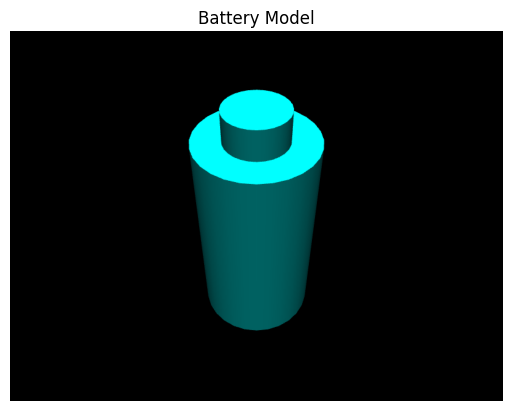

In [30]:
batteryModel.renderPixels(0,"Battery Model")

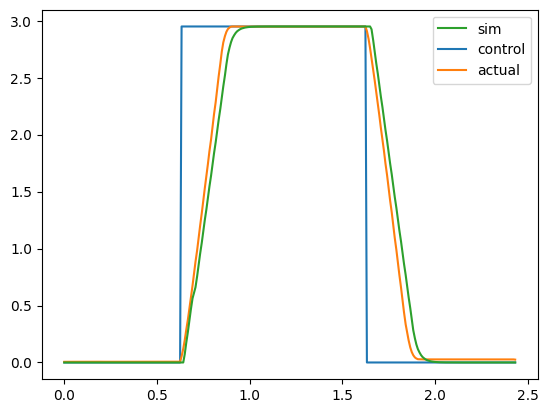

In [31]:
n = len(batteryModel.q) // len(q_data)  # Determine the step size for each timestep
battery_q_data = batteryModel.q[::n][:len(q_data)] # Take every nth value and then truncate


a2 = plt.plot(t_data,desired)
a3 = plt.plot(t_data,q_data)
a1 = plt.plot(t_data,battery_q_data)

plt.legend(a1+a2+a3,['sim','control','actual'])
plt.show()

In [32]:
def run_sim(kp, b):
    kp = kp
    b_act= b
    model = mjh(xml=xml, duration=t_data[-1], controller=mycontroller1)
    
    return model.q[::n][:len(q_data)], model

Changing $k_p$ values results in a sharp or rounded transition near the corners of my actuator’s step response.

In [33]:
q1,_ = run_sim(kp=2, b=b)
q2,_ = run_sim(kp=4, b=b)
q3,_ = run_sim(kp=20, b=b)

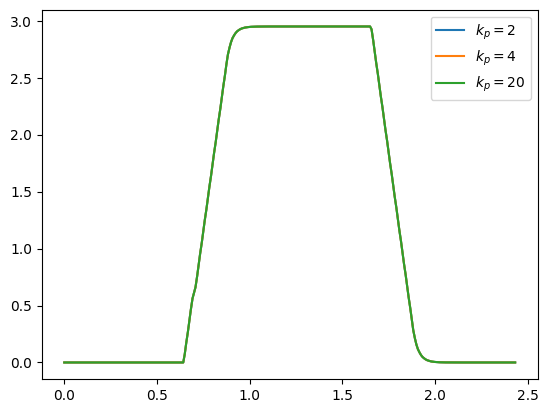

In [34]:
a1 = plt.plot(t_data,q1)
a2 = plt.plot(t_data,q2)
a3 = plt.plot(t_data,q3)
plt.legend(a1+a2+a3,['$k_p=2$','$k_p=4$','$k_p=20$'])
plt.show()

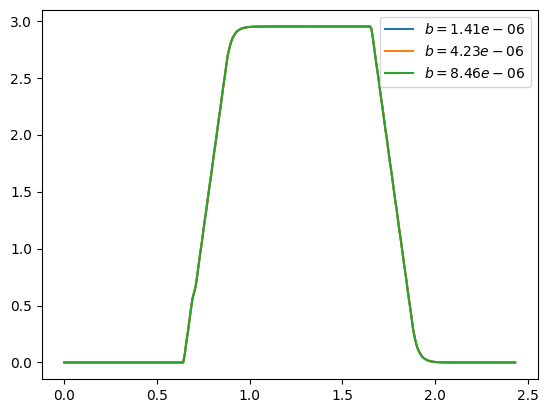

In [35]:
q1,_ = run_sim(kp = 20,b = b)
q2,_ = run_sim(kp = 20,b = b*3)
q3,_ = run_sim(kp = 20,b = b*6)

a1 = plt.plot(t_data,q1)
a2 = plt.plot(t_data,q2)
a3 = plt.plot(t_data,q3)

plt.legend(a1+a2+a3,[   '$b={b:1.2e}$'.format(b=b),
                        '$b={b:1.2e}$'.format(b=b*3),
                        '$b={b:1.2e}$'.format(b=b*6)])
plt.show()


## Parameter identification

In [36]:
def fun(vars):
    k,b = vars
    q,_ = run_sim(k,b)
    error = q-q_data
    error = error**2
    error = error.sum()
    error = error**.5
    print(k,b,error)
    return error

In [37]:
ini = [15,b]
fun(ini)

15 1.40967582379629e-06 2.3537948912995943


np.float64(2.3537948912995943)

In [38]:
results = so.minimize(fun,x0=ini,method='nelder-mead',bounds = ((1,100),(b*.1,b*10)), options={'xatol':1e-2,'fatol':1e-2})

15.0 1.40967582379629e-06 2.3537948912995943
15.75 1.40967582379629e-06 2.3537948912995943
15.0 1.4801596149861046e-06 2.3537948912995943
15.75 1.3391920326064755e-06 2.3537948912995943
15.1875 1.4449177193911974e-06 2.3537948912995943
15.375 1.40967582379629e-06 2.3537948912995943
15.0 1.4449177193911974e-06 2.3537948912995943
15.375 1.3744339282013827e-06 2.3537948912995943
15.09375 1.4272967715937437e-06 2.3537948912995943
15.1875 1.40967582379629e-06 2.3537948912995943
15.0 1.4272967715937437e-06 2.3537948912995943
15.1875 1.3920548759988364e-06 2.3537948912995943
15.046875 1.418486297695017e-06 2.3537948912995943
15.09375 1.40967582379629e-06 2.3537948912995943
15.0 1.418486297695017e-06 2.3537948912995943
15.09375 1.4008653498975631e-06 2.3537948912995943
15.0234375 1.4140810607456535e-06 2.3537948912995943
15.046875 1.40967582379629e-06 2.3537948912995943
15.0 1.4140810607456535e-06 2.3537948912995943
15.046875 1.4052705868469266e-06 2.3537948912995943
15.01171875 1.411878442270

In [39]:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.3537948912995943
             x: [ 1.500e+01  1.410e-06]
           nit: 8
          nfev: 31
 final_simplex: (array([[ 1.500e+01,  1.410e-06],
                       [ 1.501e+01,  1.410e-06],
                       [ 1.500e+01,  1.410e-06]]), array([ 2.354e+00,  2.354e+00,  2.354e+00]))

In [40]:
kp_act, b_act = results.x

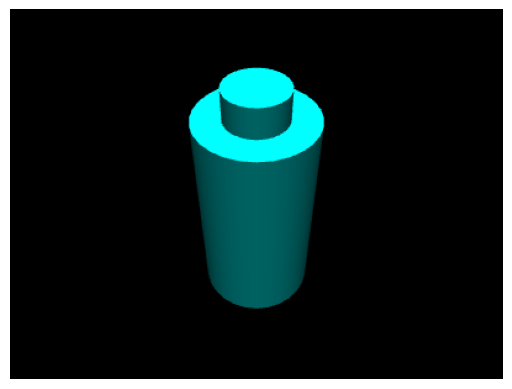

In [41]:
q , model = run_sim(kp_act,b_act)

model.renderPixels(0)

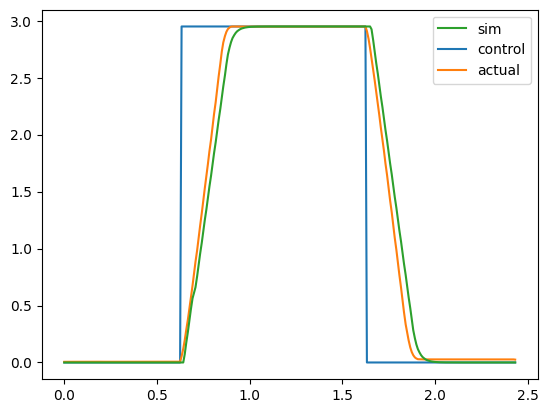

In [42]:
a2 = plt.plot(t_data,desired)
a3 = plt.plot(t_data,q_data)
a1 = plt.plot(t_data,q)
plt.legend(a1+a2+a3,['sim','control','actual'])
plt.show()

## Back Calculating Other Parameters
Using the value for b, we can now calculate more accurate values for the no-load current and kv\
\
Starting with the control law implemented above (with 𝜔 equal to the motor shaft speed rather than the output shaft speed):\
\
$\tau = \frac{k_t(V-K_ew)}{R} - b\omega$\
\
We can set 𝜏 = 0 in order to find:\
\
$\omega_{nl} = \frac{k_tV}{bR+k_tk_e}$\
\
We can then use the fact that we are lumping all losses into the damping term b, which is measured at no-load speed to equate no-load current to damping torque:\
\
$k_ti_{nl} = \omega_{nl}b$\
\
Solving for $i_{nl}$,\
\
$i_{nl} = \frac{\omega_{nl}b}{k_t}$\
\
Finally, we can obtain $k_v$ using the no-load speed and the supply voltage\
\
$k_v = \frac{V}{\omega_{nl}}$


In [43]:
V_supply = 5
w_nl_updated = kt*V_supply/(b_act*R +kt*ke)
i_nl_updated = w_nl_updated*b_act/kt
kv_updated = V_supply/w_nl_updated

print('w_nl: ',w_nl,'w_nl(updated): ',w_nl_updated)
print('i_nl: ',i_nl,'i_nl(updated): ',i_nl_updated)
print('k_v: ',kv,'k_v(updated): ',kv_updated)

w_nl:  639.1989132748913 w_nl(updated):  654.9446651315523
i_nl:  0.2 i_nl(updated):  0.20492671421357356
k_v:  0.009386749375494736 k_v(updated):  0.007634232731700623
